In [2]:
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense , Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization
from keras.applications import ResNet152V2 , MobileNetV2
from keras.preprocessing.image import ImageDataGenerator
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir,label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                new_img = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                resized_img = cv2.resize(new_img,(img_size,img_size))
                data.append([resized_img,class_num])
            except:
                continue
    return np.array(data)      
    

In [4]:
train = get_data('E:/Chest X-Ray Images/chest_xray/chest_xray/train')
test = get_data('E:/Chest X-Ray Images/chest_xray/chest_xray/test')
val = get_data('E:/Chest X-Ray Images/chest_xray/chest_xray/val')

C:\Users\Home\anaconda3\lib\site-packages\ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


In [5]:
X_train = []
y_train = []

X_test = []
y_test = []

X_val = []
y_val = []

for img,label in train:
    X_train.append(img)
    y_train.append(label)

for img,label in test:
    X_test.append(img)
    y_test.append(label)

for img,label in val:
    X_val.append(img)
    y_val.append(label)


In [6]:
X_train = np.array(X_train)/255
X_test = np.array(X_test)/255
X_val = np.array(X_val)/255

X_train = X_train.reshape(-1,img_size,img_size,1)
X_test = X_test.reshape(-1,img_size,img_size,1)
X_val = X_val.reshape(-1,img_size,img_size,1)

y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)


In [7]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [8]:
model = Sequential()

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (img_size,img_size,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())

model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1 , activation = 'sigmoid'))

model.compile(optimizer = "sgd" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0

In [9]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              patience = 2, 
                              verbose=1,
                              factor=0.25, 
                              min_lr=0.000001)

In [10]:
history = model.fit(datagen.flow(X_train,y_train,batch_size=25),epochs=10,validation_data=datagen.flow(X_test,y_test),callbacks=[reduce_lr])

Epoch 1/10
209/209 [==============================] - 995s 5s/step - loss: 0.4817 - accuracy: 0.8108 - val_loss: 2.1051 - val_accuracy: 0.6250
Epoch 2/10
209/209 [==============================] - 775s 4s/step - loss: 0.2212 - accuracy: 0.9056 - val_loss: 2.6330 - val_accuracy: 0.6250
Epoch 3/10
209/209 [==============================] - 746s 4s/step - loss: 0.1910 - accuracy: 0.9235 - val_loss: 2.6851 - val_accuracy: 0.6250

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Epoch 4/10
209/209 [==============================] - 750s 4s/step - loss: 0.1627 - accuracy: 0.9403 - val_loss: 1.0429 - val_accuracy: 0.6651
Epoch 5/10
209/209 [==============================] - 742s 4s/step - loss: 0.1676 - accuracy: 0.9403 - val_loss: 0.3152 - val_accuracy: 0.8670
Epoch 6/10
209/209 [==============================] - 744s 4s/step - loss: 0.1562 - accuracy: 0.9330 - val_loss: 0.4423 - val_accuracy: 0.8397
Epoch 7/10
209/209 [==============================] - 746s 4s

In [11]:
model.evaluate(X_test,y_test)

20/20 [==============================] - 18s 793ms/step - loss: 0.2388 - accuracy: 0.9054


[0.23875141143798828, 0.9054487347602844]

In [12]:
model.evaluate(X_val,y_val)

1/1 [==============================] - 1s 920ms/step - loss: 0.4409 - accuracy: 0.7500


[0.440920889377594, 0.75]

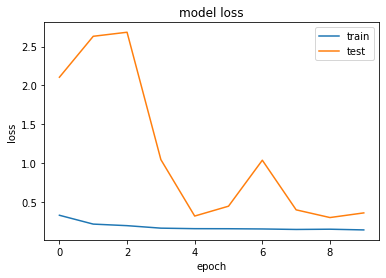

In [15]:
# plotting training set and validation test 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()